In [2]:
%matplotlib inline

from collections import defaultdict
from glob import glob
import pickle
import sqlite3
import os
from unicodedata import normalize

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns

# Variáveis de ambiente

In [3]:
PATH  = '/media/tiago/HDD - Tiago/pnad'
PATHC = '/media/tiago/HDD - Tiago/pnadc'
PATHDICT = 'assets/variaveis-educacionais-pnad-pnadc-censo-minify.csv'
ANOS_PNAD = [ano for ano in range(1976, 2016) if ano not in (1980, 1991, 1994, 2000, 2010)]
ANOS_PNADC = list(range(2016, 2022))
ANOS = ANOS_PNAD + ANOS_PNADC

# Funções de apoio

In [38]:
def sql2df(ano, sql):
    ano = int(ano)
    if ano <= 2015:
        conn_path = f'{PATH}/{ano}/pnad{ano}.sqlite'
    elif ano <= 2019:
        conn_path = glob(f'{PATHC}/suplementar-dados-educacionais/PNADC_{ano}_trimestre2_*.sqlite')[0]
    else:
        conn_path = glob(f'{PATHC}/{ano}/PNADC_02{ano}*.sqlite')[0]
    

    with sqlite3.connect(conn_path) as conn:
            df = pd.read_sql(sql, conn)
            
    return df

def aplicar_dicionário(df_, ano, cols=[], renomear_col=True, debug=False):
    ano = int(ano)
    df = df_.copy()
    if ano >= 1992 and ano <= 1999:
        df_dicionario = pd.read_csv(f'{PATH}/1999/dicionario.csv')
    elif ano >= 2000 and ano <= 2006 :
        df_dicionario = pd.read_csv(f'{PATH}/2006/dicionario.csv')
    elif ano >= 2007 and ano <= 2015 :
        df_dicionario = pd.read_csv(f'{PATH}/2011/dicionario.csv')        
    elif ano < 1992:
        try:
            df_dicionario = pd.read_csv(f'{PATH}/{ano}/dicionario-com-aux-{ano}.csv')
        except:
            df_dicionario = pd.read_csv(f'{PATH}/{ano}/dicionario.csv')
    elif ano >= 2016:
        df_dicionario = pd.read_csv(f'{PATHC}/Documentacao/dicionario.csv')

    columns = cols if cols else df.columns
    for col in columns:
        if col == 'contagem' or col.isnumeric():
            continue
        match = df_dicionario[df_dicionario.VARI == col]
        if match.empty:
            if debug:
                print(f'A variável {col} não foi encontrada!')
        elif len(match) > 1:
            print(f'Foram encontradas mais de uma entrada no dicionário para a variável {col}!')
        else:
            try:
                quesito = match.quesito.values[0]
            except AttributeError:
                quesito = match.NOME.values[0]
            try:
                categorias_dict = eval(match.categorias_dict.values[0])
            except TypeError:
                if debug:
                    print(f'Não há categoria para a variável {col}')
                continue
            
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-99999)
            
            mapper = {}
            for key, value in categorias_dict.items():
                try:
                    mapper[int(key)] = value
                except ValueError:
                    if key == '':
                        key = -99999
                    mapper[key] = value

            df[col] = df[col].astype(int).map(mapper)
            
            if renomear_col:
                df  = df.rename(columns={col:f'{col} -- {quesito}'})            
            
    return df

def normalizar_txt(txt):
    if pd.notna(txt):
        txt = txt.lower().replace(' do ', ' ')
        return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')
    else:
        return None
      
def get_var(var, ano):
    df_variaveis = pd.read_csv(PATHDICT)
    ano = int(ano)
    for ano_minimo in df_variaveis.columns[1:]:
        if ano <= int(ano_minimo):
            ano = int(ano_minimo)
            break
    return df_variaveis.loc[df_variaveis.variavel == var, str(ano)].values[0]

def corrigir_uf(col):
    df_ufs = pd.read_csv('assets/ufs_sigla_regiao.csv')
    ufs = df_ufs.UF
    siglas = df_ufs.Sigla
    dict_ufs_lower = {normalizar_txt(uf):uf for uf in ufs}
    dict_ufs_sigla = {sigla.lower():uf for sigla, uf in zip(siglas, ufs)}
    return col.apply(normalizar_txt).map(lambda x: dict_ufs_lower.get(x, dict_ufs_sigla.get(x, pd.NA)))

def corrigir_var_simples(col, path):
    df_mapper = pd.read_csv(f'assets/{path}')
    dict_mapper = {key.strip():(value.strip() if pd.notna(value) else value) for key, value in zip(df_mapper.key, df_mapper.value)}
    return col.str.strip().map(dict_mapper).str.strip()

def weighted_qcut(values, weights, q, **kwargs):
    'Return weighted quantile cuts from a given series, values.'
    'Fonte: https://stackoverflow.com/questions/45528029/python-how-to-create-weighted-quantiles-in-pandas'

    quantiles = np.linspace(0, 1, q + 1)
    order = weights.iloc[values.argsort()].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

# Matrículas da pré-escola -- faixa etária 4 e 5 anos.

In [13]:
def get_key_censo_escolar(ano, key, tipo='Matrícula'):
    '''O ano de referência é 2020 para a chave'''

    dicionário = pd.read_excel(f'/home/tiago/Dropbox/material - mestrado/scripts/csv/tabua-conversao-escola-2007a2020.xls',
                           sheet_name=f'Tabela de {tipo}')
    
    return dicionário.loc[dicionário[2020] == key, ano].values[0]

In [18]:
# id_matricula = 'ID_MATRICULA'
# nu_idade = 'NU_IDADE'
# co_uf = 'CO_UF'
# tp_etapa = 'TP_ETAPA_ENSINO'
# tp_sexo = 'TP_SEXO'
# tp_cor_raça = 'TP_COR_RACA'

# dfs_pre_escola = {}
# for ano in range(2012, 2021):
#     # TP_ETAPA 2 == pré-escola
#     sql = f'''\
#     SELECT {get_key_censo_escolar(ano, co_uf)},
#            {get_key_censo_escolar(ano, tp_sexo)},
#            {get_key_censo_escolar(ano, tp_cor_raça)},
#            COUNT(DISTINCT {get_key_censo_escolar(ano, id_matricula)}) as '{id_matricula}'
#     FROM matricula
#     WHERE {get_key_censo_escolar(ano, nu_idade)} BETWEEN 4 AND 5 
#           AND {get_key_censo_escolar(ano, tp_etapa)} == 2
#     GROUP BY {get_key_censo_escolar(ano, co_uf)},
#              {get_key_censo_escolar(ano, tp_sexo)},
#              {get_key_censo_escolar(ano, tp_cor_raça)}'''
    
#     print(sql)
#     print(ano)
#     with sqlite3.connect(f'/media/tiago/HDD - Tiago/censo_escolar/micro_censo_escolar{ano}/SQL/microdados_censo_escolar_{ano}.sqlite') as conn:
#         dfs_pre_escola[ano] = pd.read_sql(sql, conn)
#     print('---***---')
# with open('dados_pre_escola_Censo_Educ_Basica.pickle', 'wb') as f:
#     pickle.dump(dfs_pre_escola, f)

    SELECT FK_COD_ESTADO_ESCOLA,
           TP_SEXO,
           TP_COR_RACA,
           COUNT(DISTINCT PK_COD_MATRICULA) as 'ID_MATRICULA'
    FROM matricula
    WHERE NUM_IDADE BETWEEN 4 AND 5 
          AND FK_COD_ETAPA_ENSINO == 2
    GROUP BY FK_COD_ESTADO_ESCOLA,
             TP_SEXO,
             TP_COR_RACA
2012
---***---
    SELECT FK_COD_ESTADO_ESCOLA,
           TP_SEXO,
           TP_COR_RACA,
           COUNT(DISTINCT PK_COD_MATRICULA) as 'ID_MATRICULA'
    FROM matricula
    WHERE NUM_IDADE BETWEEN 4 AND 5 
          AND FK_COD_ETAPA_ENSINO == 2
    GROUP BY FK_COD_ESTADO_ESCOLA,
             TP_SEXO,
             TP_COR_RACA
2013
---***---
    SELECT FK_COD_ESTADO_ESCOLA,
           TP_SEXO,
           TP_COR_RACA,
           COUNT(DISTINCT PK_COD_MATRICULA) as 'ID_MATRICULA'
    FROM matricula
    WHERE NUM_IDADE BETWEEN 4 AND 5 
          AND FK_COD_ETAPA_ENSINO == 2
    GROUP BY FK_COD_ESTADO_ESCOLA,
             TP_SEXO,
             TP_COR_RACA
2014
---***---
    SEL

# Média de anos de estudo da população entre 25 e 64 anos

In [7]:
def make_sql_anos_estudo(ano, idade_min, idade_max):
    ano = str(ano)
    var_peso = get_var('Peso', ano)
    if pd.isna(var_peso):
        return pd.DataFrame(data={ano: [None]})
    var_uf = get_var('uf', ano)
    var_anos_estudo = get_var('Anos de Estudo', ano)
    var_idade = get_var('Idade', ano)
    var_tipo = get_var('Tipo de Registro', ano)
    if pd.notna(var_tipo):
        var_tipo, num_pessoa = var_tipo.split('-')
    sql = f'''\
SELECT {var_uf},
{var_anos_estudo},
SUM({var_peso}) as "{ano}"
FROM tabela
WHERE {var_idade} BETWEEN {idade_min} AND {idade_max}
     {f'AND {var_tipo} == {num_pessoa}' if pd.notna(var_tipo) else ''}
     GROUP BY {var_uf}, {var_anos_estudo}'''
    
    return sql

In [ ]:
# dfs = []
# for ano in ANOS:
#     print(ano, end=' ')
#     sql = make_sql_anos_estudo(ano, idade_min=25, idade_max=69)
#     dfs.append(sql2df(ano, sql))
# with open('15a64_anos_uf_anos_escolaridade.pickle', 'wb') as f:
#     pickle.dump(dfs, f)

In [11]:
with open('15a64_anos_uf_anos_escolaridade.pickle', 'rb') as f:
    dfs = pickle.load(f)
dfs_ = []
for df in dfs:
    if df.size < 2:
        continue
        
    df = aplicar_dicionário(df, df.columns[2])
    df['ano'] = int(df.columns[2])
    if len(df.columns) == 4:
        df.columns = ['uf', 'anosEstudo', 'contagem', 'ano']
    else:
        df.columns = ['uf', 'anosEstudo', 'contagem', 'trimestre', 'ano']
    dfs_.append(df)
        
df = pd.concat(dfs_, ignore_index=True)

In [12]:
df.uf = corrigir_uf(df.uf)

In [13]:
df_anos_estudo = pd.read_csv('assets/anos_estudos.csv')
dict_anos_estudo = {key:(int(value) if pd.notna(value) else value) for key, value in zip(df_anos_estudo.key, df_anos_estudo.value)}
df['anosEstudo'] = df.anosEstudo.map(dict_anos_estudo)
df.loc[df.ano >= 2016, 'anosEstudo'] -= 1

In [14]:
g_brasil = df.groupby(['ano'], dropna=False).apply(lambda g: (g.anosEstudo * g.contagem).sum()/g[g.anosEstudo.notna()].contagem.sum())
g_brasil = g_brasil.to_frame().reset_index()
g_brasil.columns = ['ano', 'média_anos_de_estudo']

In [16]:
g_ufs = df.groupby(['uf', 'ano'], dropna=False).apply(lambda g: (g.anosEstudo * g.contagem).sum()/g[g.anosEstudo.notna()].contagem.sum())
g_ufs = g_ufs.to_frame().reset_index()
g_ufs.columns = ['uf', 'ano', 'média_anos_de_estudo']

In [18]:
df_media_anos = g_ufs.set_index(['uf', 'ano']).unstack().dropna(axis=1, how='all')

In [21]:
g_brasil['uf'] = 'Brasil'
df_brasil_media_anos = g_brasil.set_index(['uf', 'ano']).unstack().dropna(axis=1, how='all')

In [55]:
pd.concat([df_brasil_media_anos, df_media_anos]).to_excel('graficos-tabelas/1a.anos_estudos_ufs.xlsx')

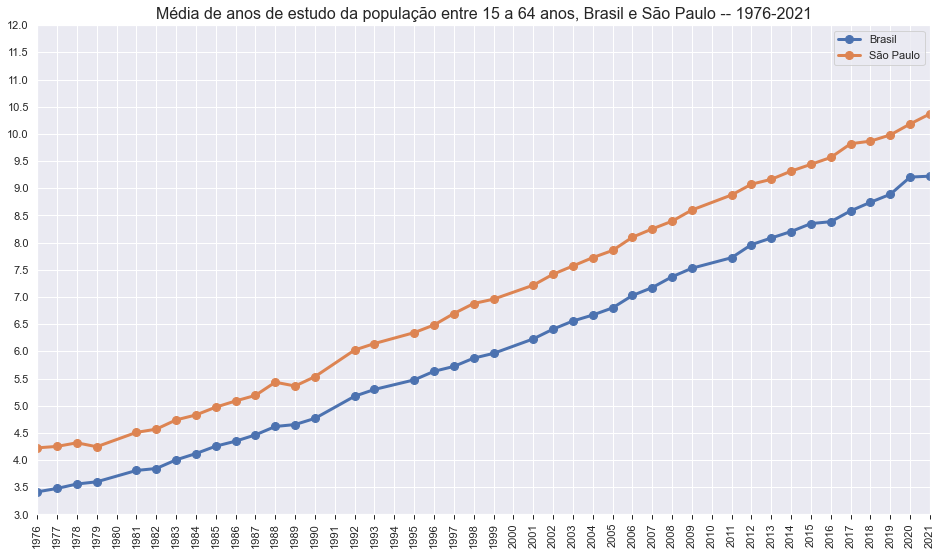

In [53]:
sns.set_theme()

X = ANOS

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', width=1.00, length=5)
ax.tick_params(which='minor', width=0.75, length=2.5)
ax.set_xlim(1976, 2021)
ax.set_ylim(3, 12)
    
ax.plot(X, g_brasil.média_anos_de_estudo, lw=3, marker='o', ms=8, label='Brasil')
ax.plot(X, g_ufs.loc[g_ufs.uf == 'São Paulo','média_anos_de_estudo'], lw=3, marker='o', ms=8, label='São Paulo')

# for uf in g_ufs.uf.value_counts().index:
#     print(uf)
#     if uf == 'Mato Grosso do Sul' or uf == 'Tocantins':
#         continue
#     ax.plot(x, g_ufs.loc[g_ufs.uf == uf,'média_anos_de_estudo'], lw=2, label=uf)
    
# 

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.xaxis.set_minor_locator(ticker.FixedLocator(np.linspace(2012, 2021.75, ((2022-2012)*4))[:-2]))
ax.xaxis.set_tick_params(rotation=90)

ax.yaxis.set_major_locator(ticker.MultipleLocator(.5))

plt.title('Média de anos de estudo da população entre 15 a 64 anos, Brasil e São Paulo -- 1976-2021', size=16)
plt.legend(frameon=True)
# plt.savefig('graficos-tabelas/1b.brasil_media_anos_estudos_15a64anos.svg')

# Gráfico 1: Taxas de atendimento educacional da população de 4 a 17 anos, por faixas etárias (4 a 5, 6 a 14 e 15 a 17)

In [27]:
def make_sql_taxa_atendimento(ano, idade_min=0, idade_max=100):
    ano = str(ano)
    var_peso = get_var('Peso', ano)
    if pd.isna(var_peso):
        return pd.DataFrame(data={ano: [None]})
    var_uf = get_var('uf', ano)
    var_frequenta = get_var('Frequenta Escola', ano)
    var_idade = get_var('Idade', ano)
    var_tipo = get_var('Tipo de Registro', ano)
    if pd.notna(var_tipo):
        var_tipo, num_pessoa = var_tipo.split('-')
    sql = f'''\
SELECT {var_uf},
{var_idade},
{var_frequenta},
SUM({var_peso}) as "{ano}"
FROM tabela
WHERE {var_idade} >= {idade_min} 
      AND {var_idade} <= {idade_max}
     {f'AND {var_tipo} == {num_pessoa}' if pd.notna(var_tipo) else ''}
     GROUP BY {var_uf}, {var_idade}, {var_frequenta}'''
    
    return sql

In [ ]:
# dfs = []
# for ano in ANOS:
#     print(ano)
#     sql = make_sql_taxa_atendimento(ano, idade_min=4, idade_max=17)
#     dfs.append(sql2df(ano, sql))
    
# with open('taxa_atendimento_4a17anos.pickle', 'wb') as f:
#     pickle.dump(dfs, f)

In [6]:
with open('taxa_atendimento_4a17anos.pickle', 'rb') as f:
    dfs = pickle.load(f)
dfs_ = []
for df in dfs:
    df = aplicar_dicionário(df, df.columns[3], cols=list(df.columns[:3:2]))
    df['ano'] = int(df.columns[3])
    df.columns = ['uf', 'idade', 'frequenta', 'contagem', 'ano']
    dfs_.append(df)
        
df = pd.concat(dfs_, ignore_index=True)

In [7]:
df.uf = corrigir_uf(df.uf)
df.idade = df.idade.astype(int)
df.frequenta = corrigir_var_simples(df.frequenta, 'frequenta.csv')

In [17]:
def atendimento(df, idade_between):
    g_brasil = (df[df.idade.between(*idade_between)]
                  .groupby(['ano'], dropna=False)
                  .apply(lambda g: g.loc[g.frequenta == 'Sim', 'contagem'].sum()/g.loc[g.frequenta.isin(['Sim', 'Não']), 'contagem'].sum()))
    g_brasil = g_brasil.to_frame().reset_index()
    g_brasil.columns = ['ano', 'frequenta']
    g_ufs = (df[df.idade.between(*idade_between)]
                  .groupby(['ano', 'uf'], dropna=False)
                  .apply(lambda g: g.loc[g.frequenta == 'Sim', 'contagem'].sum()/g.loc[g.frequenta.isin(['Sim', 'Não']), 'contagem'].sum()))
    g_ufs = g_ufs.to_frame().reset_index()
    g_ufs.columns = ['ano', 'uf', 'frequenta']
    
    df = g_ufs.set_index(['uf', 'ano']).unstack().dropna(axis=1, how='all')
    g_brasil['uf'] = 'Brasil'
    df_brasil = g_brasil.set_index(['uf', 'ano']).unstack().dropna(axis=1, how='all')
    return g_ufs, g_brasil, pd.concat([df_brasil, df])

def grafico_atendimento(g_brasil, g_ufs, titulo, faixa_etaria):
    sns.set_theme()

    X = g_brasil.ano

    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(1, 1, 1)

    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00, length=5)
    ax.tick_params(which='minor', width=0.75, length=2.5)
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(0, 100)

    ax.plot(X, g_brasil.frequenta*100, lw=3, marker='o', ms=8, label='Brasil')
    ax.plot(X, g_ufs.loc[g_ufs.uf == 'São Paulo','frequenta']*100, lw=3, marker='o', ms=8, label='São Paulo')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_tick_params(rotation=90)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    
    plt.title(titulo, size=16)
    plt.legend(frameon=True, loc='upper left')
    # plt.savefig(f'graficos-tabelas/2c.brasil_atendimento_{faixa_etaria}.svg')

In [18]:
g_ufs_EI, g_brasil_EI, df_atendimento_EI = atendimento(df, (4, 5))
g_ufs_EF, g_brasil_EF, df_atendimento_EF = atendimento(df, (6, 14))
g_ufs_EM, g_brasil_EM, df_atendimento_EM = atendimento(df, (15, 17))

In [73]:
df_atendimento_EF.to_excel('graficos-tabelas/2a.taxa-atendimento-6a14anos.xlsx')
df_atendimento_EM.to_excel('graficos-tabelas/2b.taxa-atendimento-15a17anos.xlsx')

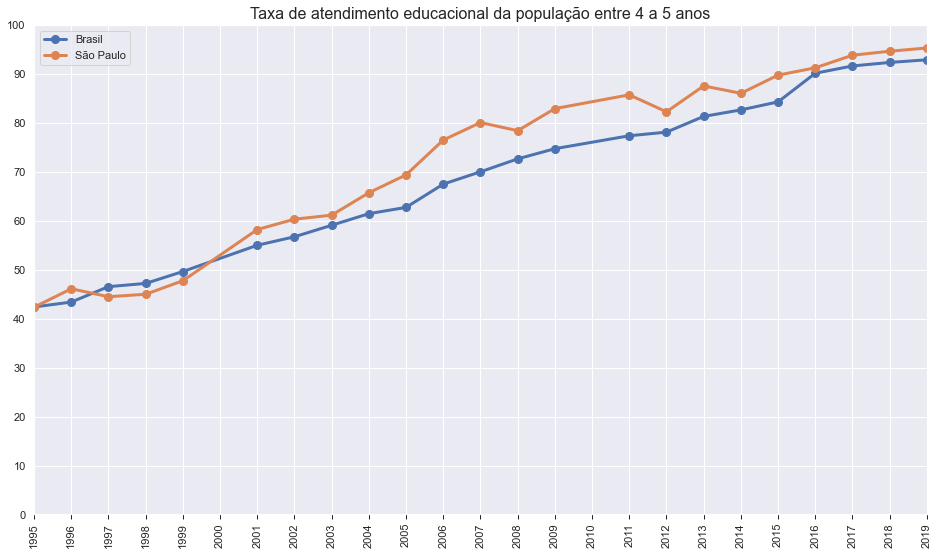

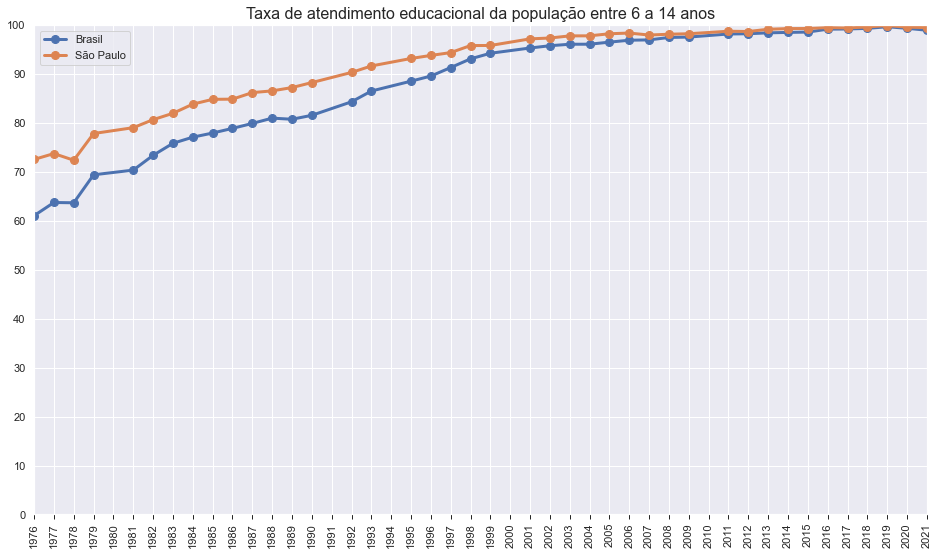

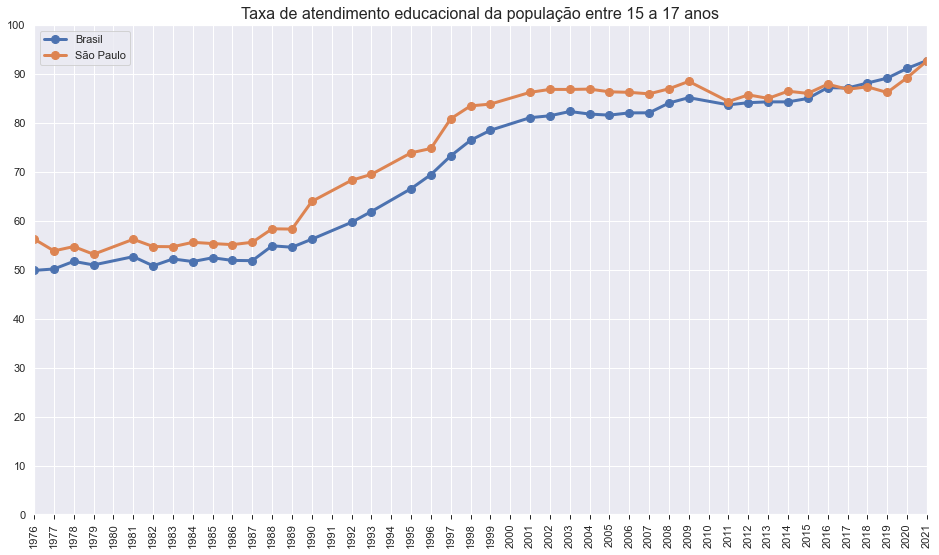

In [19]:
grafico_atendimento(g_brasil_EI[g_brasil_EI.ano.between(1995, 2019)], g_ufs_EI[g_ufs_EI.ano.between(1995, 2019)], 'Taxa de atendimento educacional da população entre 4 a 5 anos', '5a6anos')
grafico_atendimento(g_brasil_EF, g_ufs_EF, 'Taxa de atendimento educacional da população entre 6 a 14 anos' , '6a14anos')
grafico_atendimento(g_brasil_EM, g_ufs_EM, 'Taxa de atendimento educacional da população entre 15 a 17 anos', '15a17anos')

# Gráfico 2: Taxas de escolarização líquida da população de 4 a 17 anos, segundo nível de ensino

Para agrupar por domicílios utilizar as variáveis UPA (Unidade Primária de Amostragem) e V1008 (Número de seleção do domicílio)

In [15]:
# def make_sql_escolarizacao_liquida(ano, trimestre=None):
#     ano = str(ano)
#     var_peso = get_var('Peso', ano)
#     if pd.isna(var_peso):
#         return 
    
#     var_uf = get_var('uf', ano)
#     var_idade = get_var('Idade', ano)
#     var_tipo = get_var('Tipo de Registro', ano)
#     var_UPA = get_var('Unidade primaria de amostragem', ano)
#     var_sexo = get_var('Sexo', ano)
#     var_raca = get_var('Raça', ano)
#     var_domicilio = get_var('Numero de selecao do domicilio', ano)
#     var_curso = get_var('Grau Escola', (str(int(ano) + 1) if (ano == '2015' and trimestre == 4) else ano))
#     if pd.notna(var_tipo):
#         var_tipo, num_pessoa = var_tipo.split('-')
    
#     VD4020 = 'VD4020' # Rendimento mensal efetivo de todos os trabalhos
    
#     sql = f'''\
# SELECT {var_uf},
# {var_UPA} || {var_domicilio} as "id_dom",
# {var_idade},
# {var_curso},
# {var_sexo},
# {var_raca},
# {VD4020},
# {var_peso}
# FROM tabela'''
    
    # return sql

def make_sql_escolarizacao_liquida(ano):
    ano = str(ano)
    var_peso = get_var('Peso', ano)
    
    var_uf = get_var('uf', ano)
    var_idade = get_var('Idade', ano)
    var_tipo = get_var('Tipo de Registro', ano)
    var_sexo = get_var('Sexo', ano)
    var_raca = get_var('Raça', ano)
    var_domicilio = get_var('Numero de selecao do domicilio', ano)
    var_curso = get_var('Grau Escola', ano)
    if pd.notna(var_tipo):
        var_tipo, num_pessoa = var_tipo.split('-')
    
    sql = f'''\
SELECT {var_uf},       
       {var_curso},
       {var_sexo + ',' if pd.notna(var_sexo) else ''}
       {var_raca + ',' if pd.notna(var_raca) else ''}
       {var_idade},
       {var_peso}
FROM tabela
WHERE  {var_idade} BETWEEN 4 AND 17
       {f'AND {var_tipo} == {num_pessoa}' if pd.notna(var_tipo) else ''}'''
    
    return sql

In [8]:
# def fazer_quintis(df):
#     g = df.groupby('id_dom').apply(lambda g: g.VD4020.sum()/g.shape[0])
#     df_ = df.merge(g.to_frame('renda_per_capita').reset_index(), how='left')
#     df_renda = df_[['id_dom', 'V1028', 'renda_per_capita']].drop_duplicates()
#     df_renda['quintis'] = weighted_qcut(df_renda.renda_per_capita, df_renda.V1028, 5,
#                                     labels=['1º quintil', '2º quintil', '3º quintil', '4º quintil', '5º quintil'])
#     return df.merge(df_renda)

In [46]:
def fazer_tab_liquida(dfs, ano):
    sql = make_sql_escolarizacao_liquida(ano)
    df = sql2df(ano, sql)
    var_sexo = get_var('Sexo', ano)
    if pd.notna(var_sexo):
        df.loc[:, [var_sexo]] = df.loc[:, [var_sexo]].astype('category')
    var_raca = get_var('Raça', ano)
    if pd.notna(var_raca):
        df.loc[:, [var_raca]] = df.loc[:, [var_raca]].astype('category')    
    df.iloc[:, [0,1]] = df.iloc[:, [0,1]].astype('category')
    dfs[ano] = df
    
# dfs = {}
# for ano in ANOS:
#     print(ano, end=' ')
#     sql = make_sql_escolarizacao_liquida(ano)
#     df = sql2df(ano, sql)       
#     var_sexo = get_var('Sexo', ano)
#     if pd.notna(var_sexo):
#         df.loc[:, [var_sexo]] = df.loc[:, [var_sexo]].astype('category')
#     var_raca = get_var('Raça', ano)
#     if pd.notna(var_raca):
#         df.loc[:, [var_raca]] = df.loc[:, [var_raca]].astype('category')    
#     df.iloc[:, [0,1]] = df.iloc[:, [0,1]].astype('category')
#     dfs[ano] = df

# with open('/home/tiago/Desktop/taxa_escol_liquida_raca_sexo.pickle', 'rb') as f:
#     dfs = pickle.load(f)


# with open('/home/tiago/Desktop/taxa_escol_liquida_raca_sexo.pickle', 'wb') as f:
#     pickle.dump(dfs, f)

In [40]:
with open('/home/tiago/Desktop/taxa_escol_liquida_raca_sexo.pickle', 'rb') as f:
    dfs = pickle.load(f)
    
# with open('dados_pre_escola_Censo_Educ_Basica.pickle', 'rb') as f:
#     dfs_pre_escola = pickle.load(f)

In [53]:
dfs_tmp = []
for ano, df in dfs.items():
    df = aplicar_dicionário(df, ano, cols=list(df.columns[:-2]))
    if df.shape[1] == 5:
        df.columns = ['uf', 'grau', 'sexo', 'idade', 'peso']
    elif df.shape[1] == 6:
        df.columns = ['uf', 'grau', 'sexo', 'raça', 'idade', 'peso']
    df['ano'] = ano
    dfs_tmp.append(df)
df = pd.concat(dfs_tmp, ignore_index=True)

In [54]:
# corrigir_var_simples
df.uf = corrigir_uf(df.uf)
df.grau = corrigir_var_simples(df.grau, path='padronizar_grau.csv')
df.sexo = corrigir_var_simples(df.sexo, path='padronizar_sexo.csv')
df.raça = corrigir_var_simples(df.raça, path='padronizar_raça.csv')

In [55]:
# cf. https://sidra.ibge.gov.br/tabela/7141#resultado
ano = 1995
(df.loc[(df.ano == ano) & df.idade.between(6, 14) & (df.grau.isin(['EF', 'EM', 'ES'])), 'peso'].sum() 
/ df.loc[(df.ano == ano) & df.idade.between(6, 14), 'peso'].sum())

0.7828572008134229

In [79]:
def serie_historica(df, var, etapa, filtro_uf=None):
    ano_min, ano_max = 1976, 2021
    if var == 'raça':
        ano_min = 1989
    if etapa == 'PE':
        ano_min = 1996
        ano_max = 2019
        
    dfs = []
    grupos = df[df.ano.between(ano_min, ano_max)].groupby('ano')
    for ano, grupo in grupos:
        df_tmp = agrupar(var, ano, etapa, grupo, filtro_uf).to_frame(ano)
        dfs.append(df_tmp)
        
    return pd.concat(dfs, axis=1)

def agrupar(var, ano, etapa, df, filtro_uf=None):
    df = df.copy()
    if var == 'raça':
        df[var] = df[var].map(lambda x: 'Branca' if x == 'Branca' else 'Não Branca')                   
        
    if filtro_uf is not None:
        df = df[df.uf == filtro_uf]
            
    if etapa == 'PE':
        idade = (4, 5)
        etapas = set(['PE', 'EF', 'EM', 'ES'])
    elif etapa == 'EF':
        if ano <= 2011:
            idade = (7, 14)
        else:
            idade = (6, 14)
        etapas = set(['EF', 'EM', 'ES'])
    elif etapa == 'EM':
        idade = (15, 17)
        etapas = set(['EM', 'ES'])
    
    df = df[df.idade.between(*idade)]
            
    s = (df.groupby(var, dropna=True)
         .apply(lambda g: g.loc[g.grau.isin(etapas), 'peso'].sum()/g.peso.sum()))   

    total = df.loc[df.grau.isin(etapas), 'peso'].sum() / df['peso'].sum()

    return pd.Series({'Total': total}).append(s)

def grafico_escolaridade_liquida(df, vars_, labels, titulo):
    sns.set_theme()

   
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(1, 1, 1)

    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(which='major', width=1.00, length=5)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_tick_params(rotation=90)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    for var, label in zip(vars_, labels):
        ax.plot(df.columns, df.loc[var]*100, lw=3, marker='o', ms=12, label=label)
    plt.title(titulo, size=16)
    plt.legend(frameon=True)
    ax.set_ylim(0, 100)
    return ax

### Total

In [59]:
PE_ufs = serie_historica(df, 'uf', 'PE')
EF_ufs = serie_historica(df, 'uf', 'EF')
EM_ufs = serie_historica(df, 'uf', 'EM')

(1976.0, 2021.0)

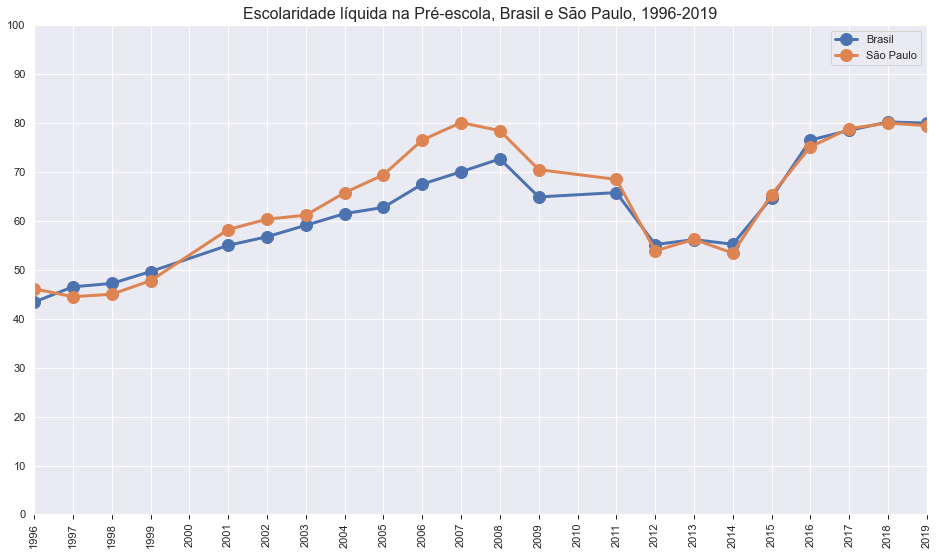

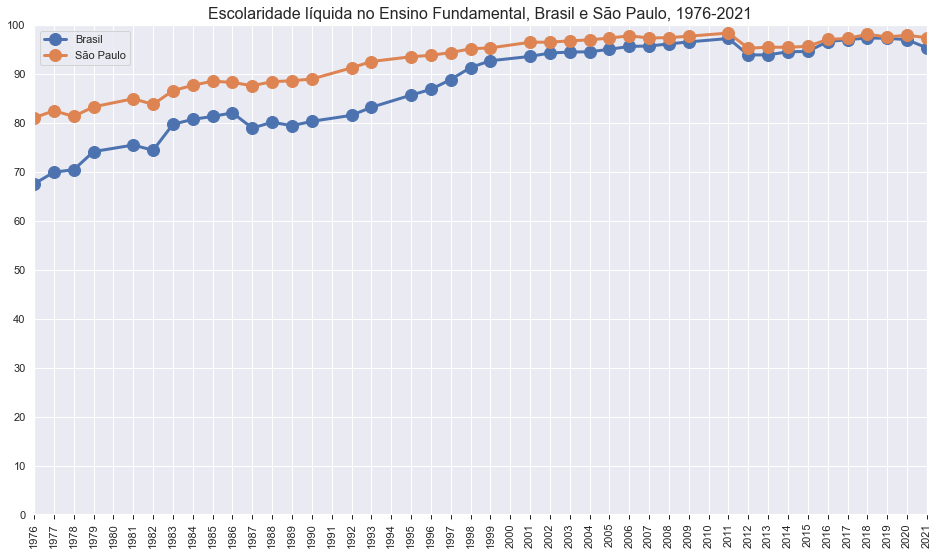

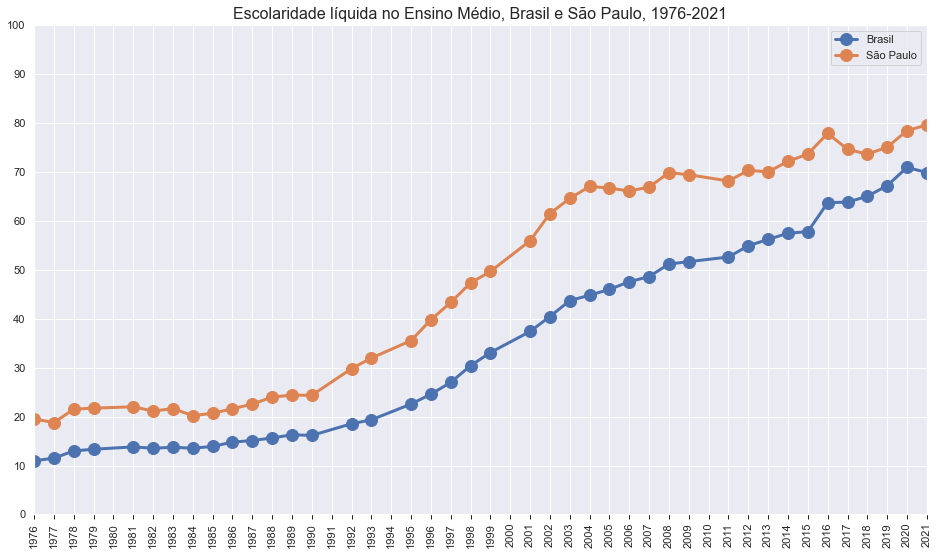

In [82]:
ax = grafico_escolaridade_liquida(PE_ufs,
                                     ['Total', 'São Paulo'],
                                     ['Brasil', 'São Paulo'],
                                     'Escolaridade líquida na Pré-escola, Brasil e São Paulo, 1996-2019')
ax.set_xlim(1996, 2019)
ax = grafico_escolaridade_liquida(EF_ufs,
                                     ['Total', 'São Paulo'],
                                     ['Brasil', 'São Paulo'],
                                     'Escolaridade líquida no Ensino Fundamental, Brasil e São Paulo, 1976-2021')
ax.set_xlim(1976, 2021)
ax = grafico_escolaridade_liquida(EM_ufs,
                                     ['Total', 'São Paulo'],
                                     ['Brasil', 'São Paulo'],
                                     'Escolaridade líquida no Ensino Médio, Brasil e São Paulo, 1976-2021')
ax.set_xlim(1976, 2021)

In [100]:
# EF_ufs.to_excel('graficos-tabelas/3a.taxa-escolarizacao-liquida-EF.xlsx')
# EM_ufs.to_excel('graficos-tabelas/3b.taxa-escolarizacao-liquida-EM.xlsx')

### Quintil de renda

In [9]:
EF_renda, EM_renda = agrupar('quintis', dfs)
EF_SP_renda, EM_SP_renda = agrupar('quintis', dfs, filtro_uf='35')

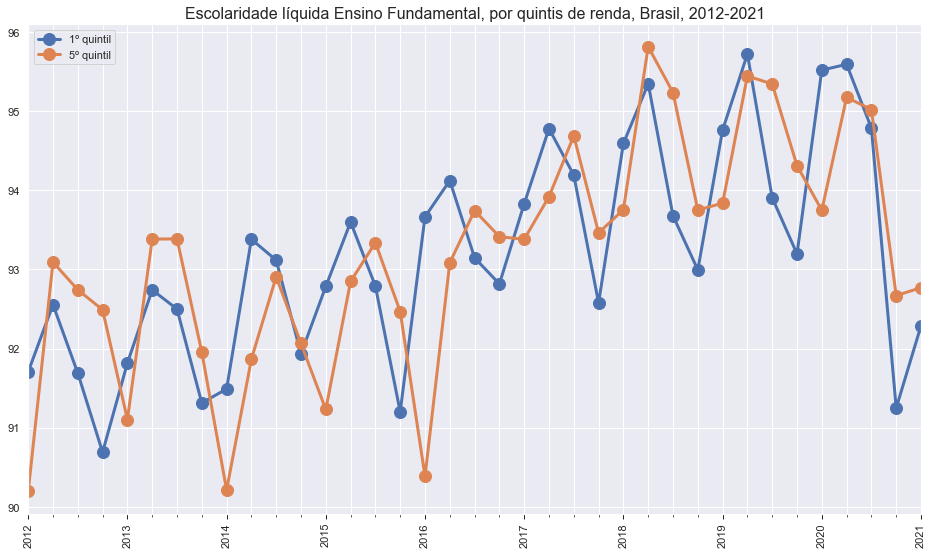

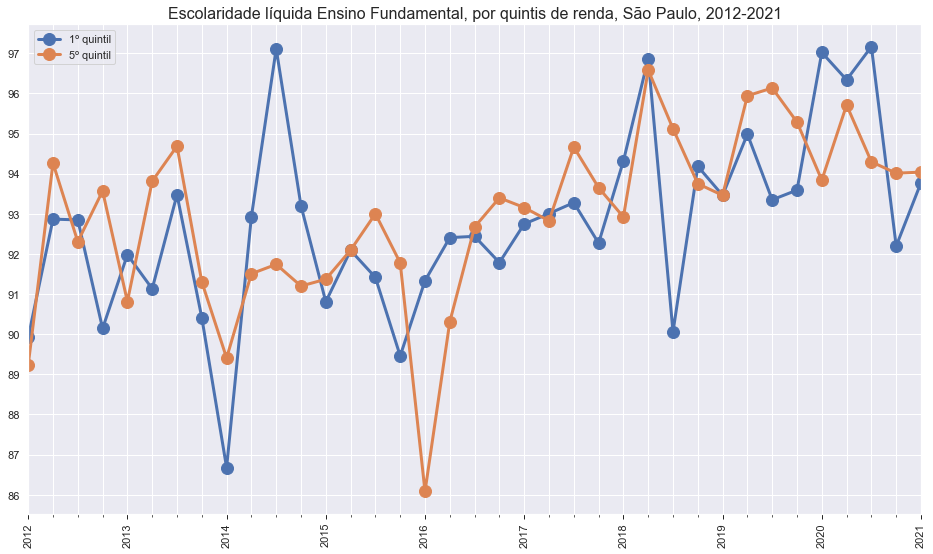

In [95]:
x, ax = grafico_escolaridade_liquida(EF_renda, 'Escolaridade líquida Ensino Fundamental, por quintis de renda, Brasil, 2012-2021')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.plot(x, EF_renda.loc['1º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='1º quintil')
ax.plot(x, EF_renda.loc['5º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='5º quintil')
plt.legend(frameon=True)
plt.savefig(f'graficos-tabelas/4c.escolaridade-liquida-EF-Brasil.svg')
x, ax = grafico_escolaridade_liquida(EF_SP_renda, 'Escolaridade líquida Ensino Fundamental, por quintis de renda, São Paulo, 2012-2021')
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.plot(x, EF_SP_renda.loc['1º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='1º quintil')
ax.plot(x, EF_SP_renda.loc['5º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='5º quintil')
plt.legend(frameon=True)
plt.savefig(f'graficos-tabelas/4d.escolaridade-liquida-EF-SP.svg')

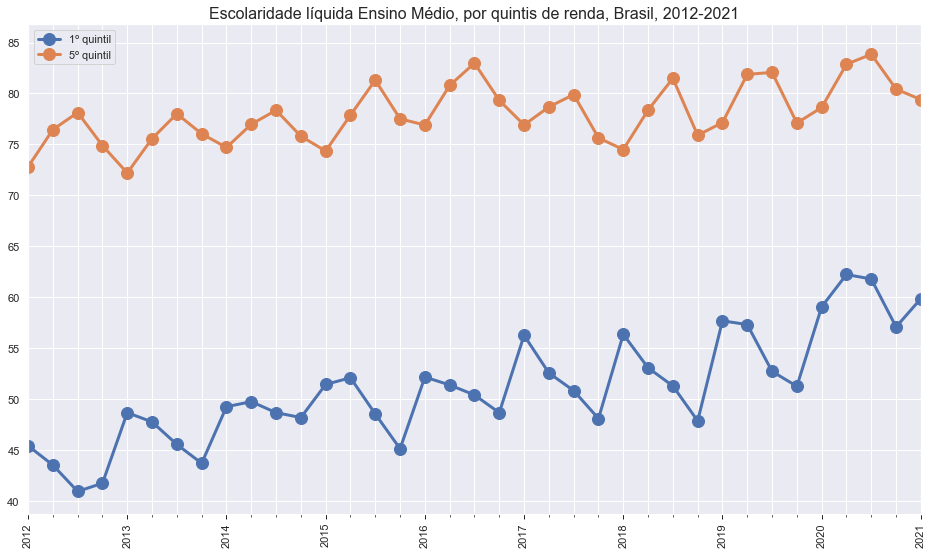

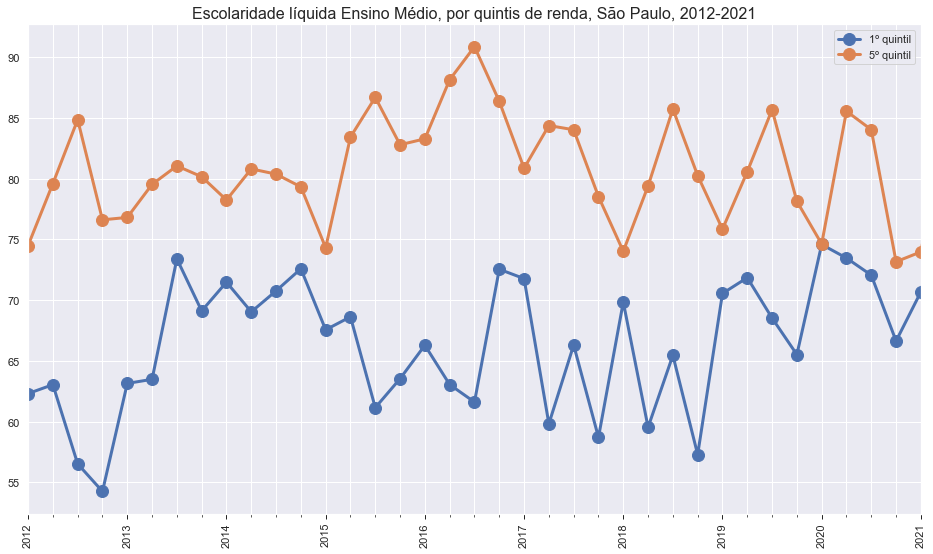

In [96]:
x, ax = grafico_escolaridade_liquida(EM_renda, 'Escolaridade líquida Ensino Médio, por quintis de renda, Brasil, 2012-2021')
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.plot(x, EM_renda.loc['1º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='1º quintil')
ax.plot(x, EM_renda.loc['5º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='5º quintil')
plt.legend(frameon=True)
plt.savefig(f'graficos-tabelas/4e.escolaridade-liquida-EM-Brasil.svg')
x, ax = grafico_escolaridade_liquida(EM_SP_renda, 'Escolaridade líquida Ensino Médio, por quintis de renda, São Paulo, 2012-2021')
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.plot(x, EM_SP_renda.loc['1º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='1º quintil')
ax.plot(x, EM_SP_renda.loc['5º quintil'].iloc[:-2]*100, lw=3, marker='o', ms=12, label='5º quintil')
plt.legend(frameon=True)
plt.savefig(f'graficos-tabelas/4f.escolaridade-liquida-EM-SP.svg')

In [102]:
# pd.concat([EF_renda, EF_SP_renda]).to_excel('graficos-tabelas/4a.taxa-escolarizacao-liquida-EF-quintis.xlsx')
# pd.concat([EM_renda, EM_SP_renda]).to_excel('graficos-tabelas/4b.taxa-escolarizacao-liquida-EM-quintis.xlsx')

### Gênero

In [67]:
PE_sexo, PE_sexo_SP = serie_historica(df, 'sexo', 'PE'), serie_historica(df, 'sexo', 'PE', filtro_uf='São Paulo')
EF_sexo, EF_sexo_SP = serie_historica(df, 'sexo', 'EF'), serie_historica(df, 'sexo', 'EF', filtro_uf='São Paulo')
EM_sexo, EM_sexo_SP = serie_historica(df, 'sexo', 'EM'), serie_historica(df, 'sexo', 'EM', filtro_uf='São Paulo')

(1976.0, 2021.0)

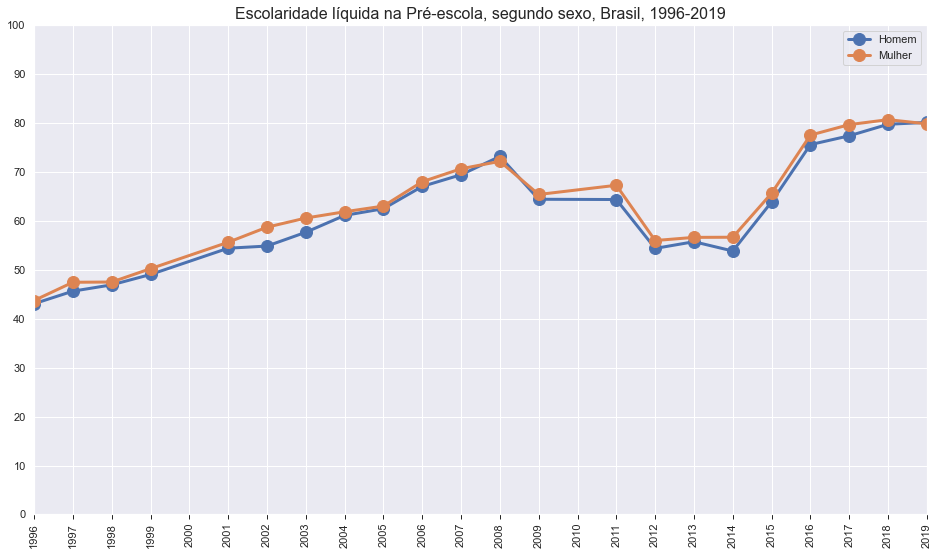

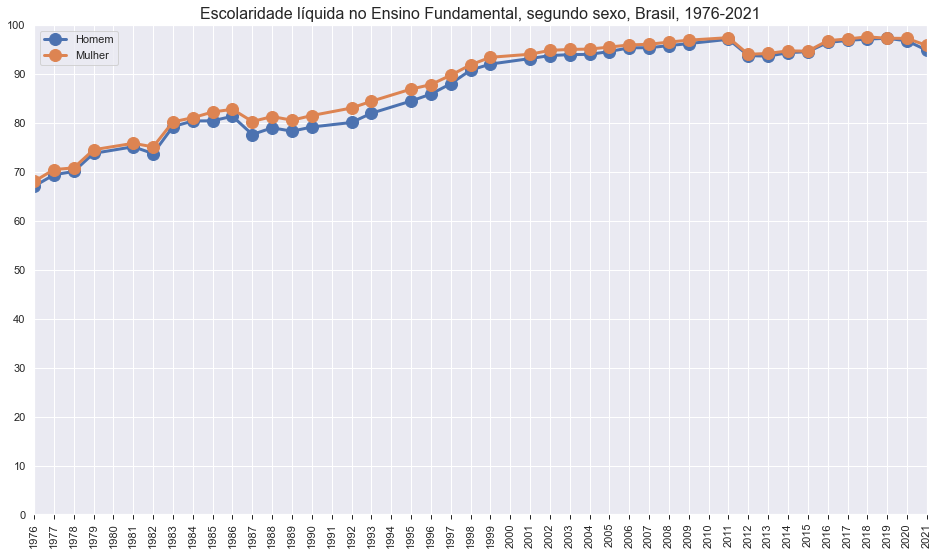

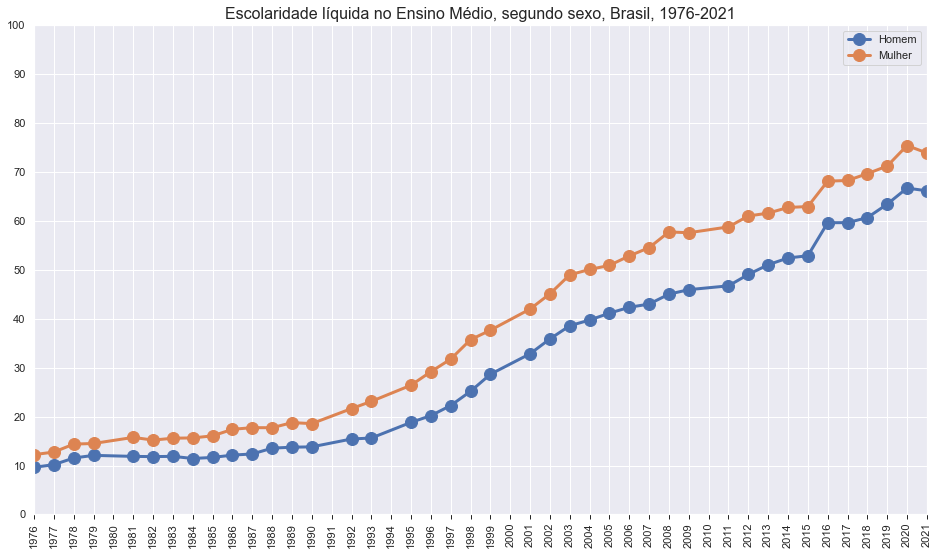

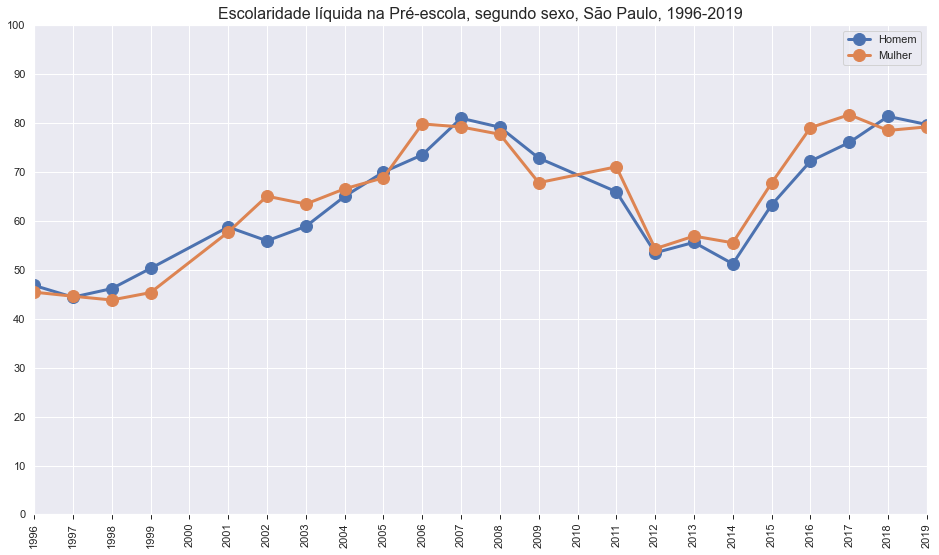

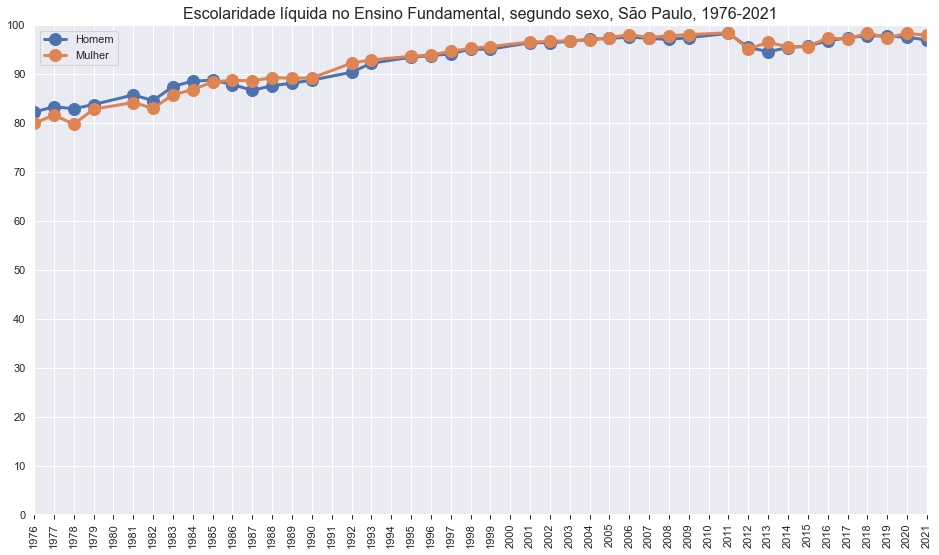

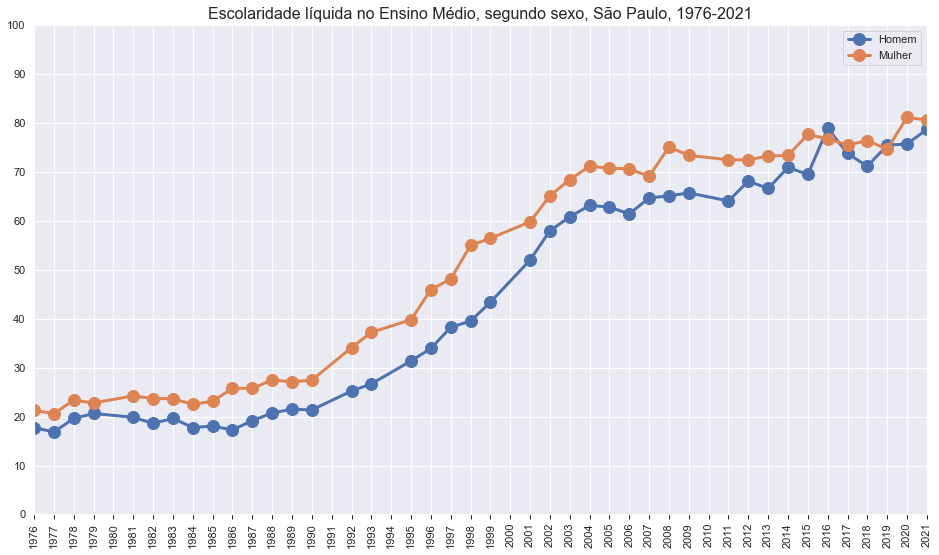

In [81]:
ax = grafico_escolaridade_liquida(PE_sexo,
                                     ['Homem', 'Mulher'],
                                     ['Homem', 'Mulher'],
                                     'Escolaridade líquida na Pré-escola, segundo sexo, Brasil, 1996-2019')
ax.set_xlim(1996, 2019)
ax = grafico_escolaridade_liquida(EF_sexo,
                                     ['Homem', 'Mulher'],
                                     ['Homem', 'Mulher'],
                                     'Escolaridade líquida no Ensino Fundamental, segundo sexo, Brasil, 1976-2021')
ax.set_xlim(1976, 2021)
ax = grafico_escolaridade_liquida(EM_sexo,
                                     ['Homem', 'Mulher'],
                                     ['Homem', 'Mulher'],
                                     'Escolaridade líquida no Ensino Médio, segundo sexo, Brasil, 1976-2021')
ax.set_xlim(1976, 2021)
ax = grafico_escolaridade_liquida(PE_sexo_SP,
                                     ['Homem', 'Mulher'],
                                     ['Homem', 'Mulher'],
                                     'Escolaridade líquida na Pré-escola, segundo sexo, São Paulo, 1996-2019')
ax.set_xlim(1996, 2019)
ax = grafico_escolaridade_liquida(EF_sexo_SP,
                                     ['Homem', 'Mulher'],
                                     ['Homem', 'Mulher'],
                                     'Escolaridade líquida no Ensino Fundamental, segundo sexo, São Paulo, 1976-2021')
ax.set_xlim(1976, 2021)
ax = grafico_escolaridade_liquida(EM_sexo_SP,
                                     ['Homem', 'Mulher'],
                                     ['Homem', 'Mulher'],
                                     'Escolaridade líquida no Ensino Médio, segundo sexo, São Paulo, 1976-2021')
ax.set_xlim(1976, 2021)

In [104]:
# pd.concat([EF_genero, EF_SP_genero]).to_excel('graficos-tabelas/5a.taxa-escolarizacao-liquida-EF-genero.xlsx')
# pd.concat([EM_genero, EM_SP_genero]).to_excel('graficos-tabelas/5b.taxa-escolarizacao-liquida-EM-genero.xlsx')

### Raça

In [74]:
PE_raça, PE_raça_SP = serie_historica(df, 'raça', 'PE'), serie_historica(df, 'raça', 'PE', filtro_uf='São Paulo')
EF_raça, EF_raça_SP = serie_historica(df, 'raça', 'EF'), serie_historica(df, 'raça', 'EF', filtro_uf='São Paulo')
EM_raça, EM_raça_SP = serie_historica(df, 'raça', 'EM'), serie_historica(df, 'raça', 'EM', filtro_uf='São Paulo')

In [106]:
# pd.concat([EF_raça, EF_SP_raça]).to_excel('graficos-tabelas/6a.taxa-escolarizacao-liquida-EF-raca.xlsx')
# pd.concat([EM_raça, EM_SP_raça]).to_excel('graficos-tabelas/6b.taxa-escolarizacao-liquida-EM-raca.xlsx')

(1989.0, 2021.0)

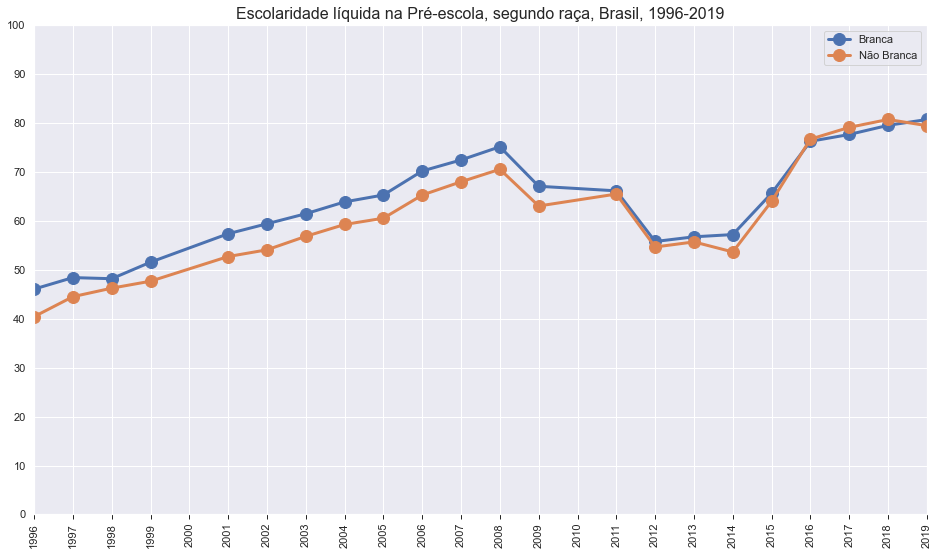

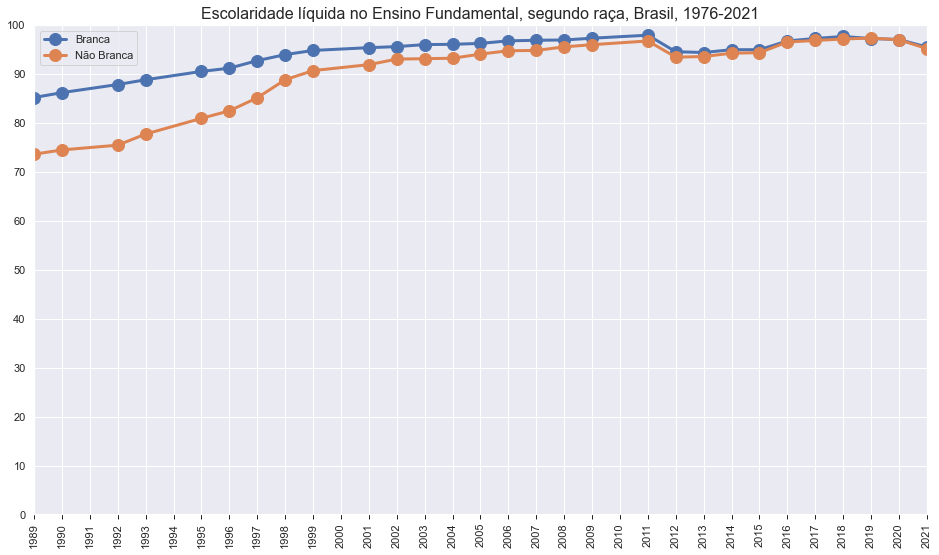

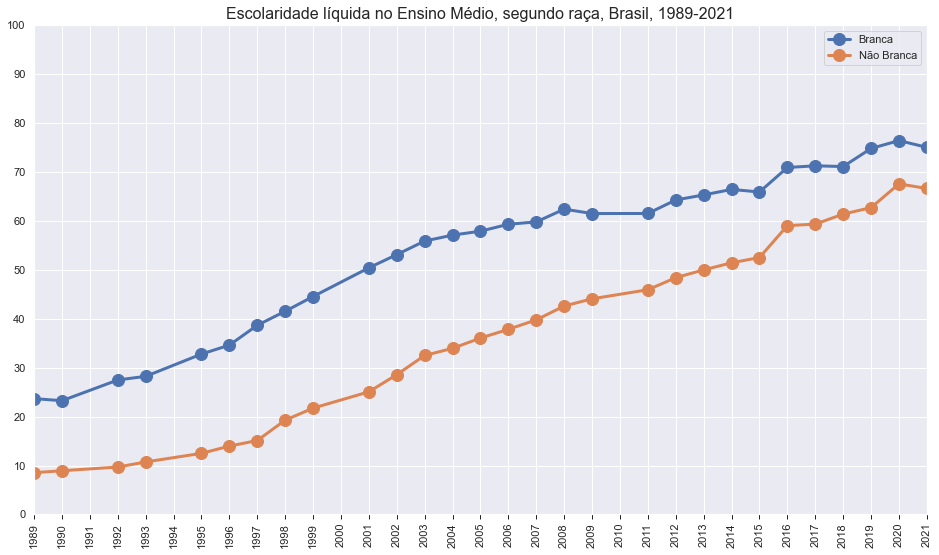

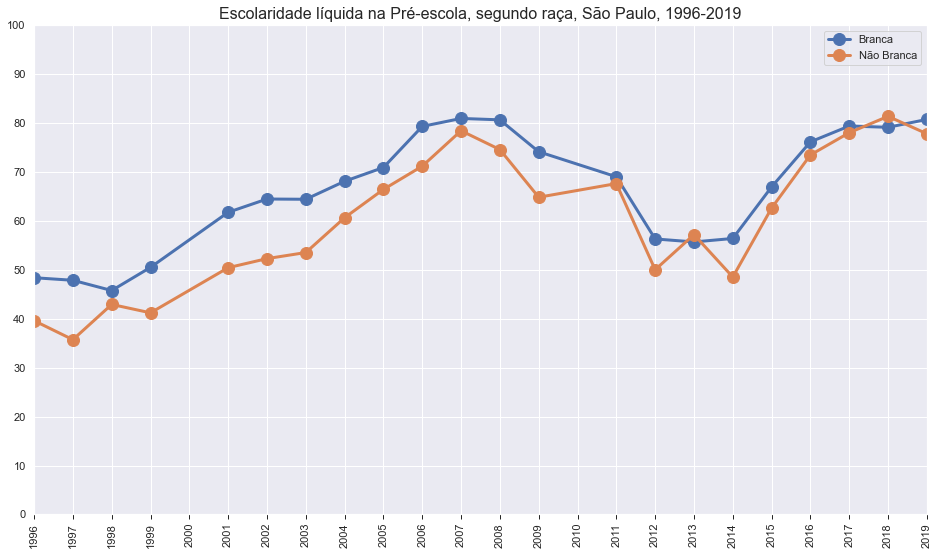

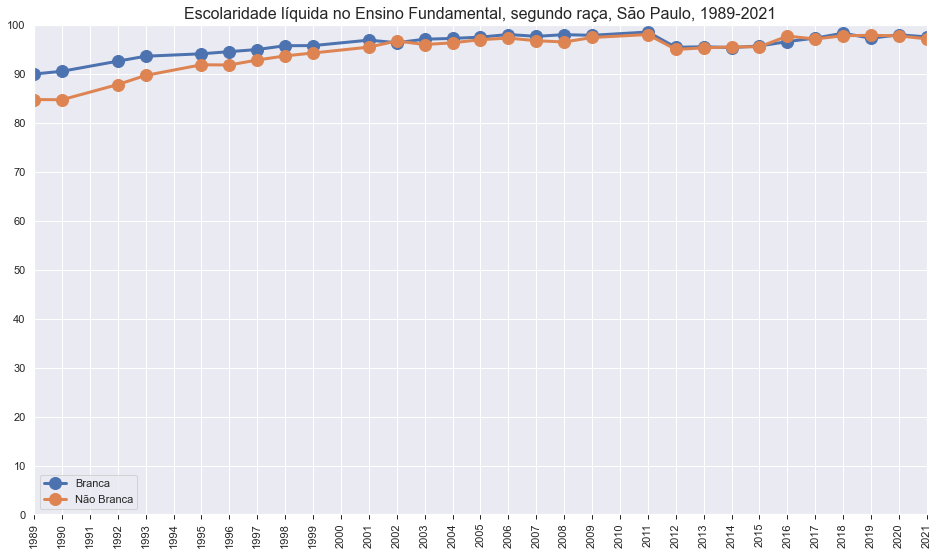

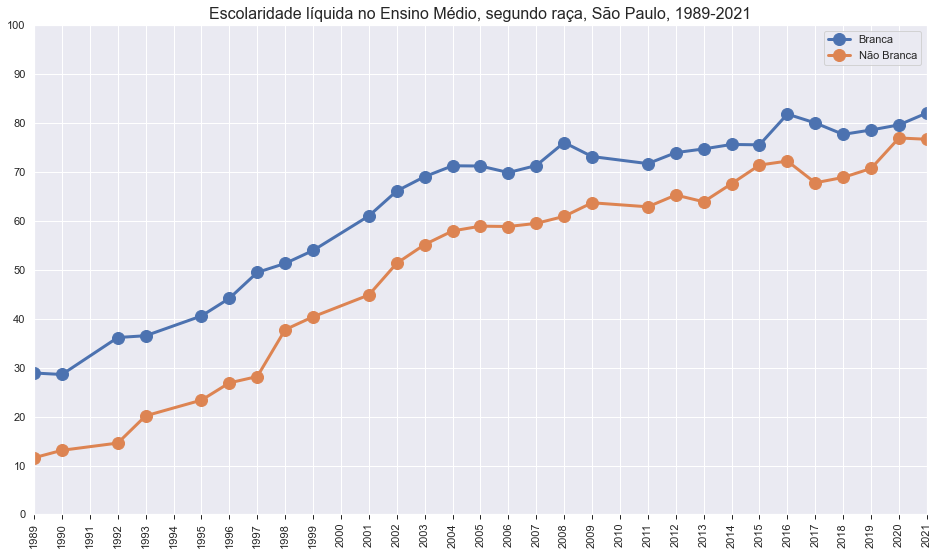

In [80]:
ax = grafico_escolaridade_liquida(PE_raça,
                                     ['Branca', 'Não Branca'],
                                     ['Branca', 'Não Branca'],
                                     'Escolaridade líquida na Pré-escola, segundo raça, Brasil, 1996-2019')
ax.set_xlim(1996, 2019)
ax = grafico_escolaridade_liquida(EF_raça,
                                     ['Branca', 'Não Branca'],
                                     ['Branca', 'Não Branca'],
                                     'Escolaridade líquida no Ensino Fundamental, segundo raça, Brasil, 1976-2021')
ax.set_xlim(1989, 2021)
ax = grafico_escolaridade_liquida(EM_raça,
                                     ['Branca', 'Não Branca'],
                                     ['Branca', 'Não Branca'],
                                     'Escolaridade líquida no Ensino Médio, segundo raça, Brasil, 1989-2021')
ax.set_xlim(1989, 2021)
ax = grafico_escolaridade_liquida(PE_raça_SP,
                                     ['Branca', 'Não Branca'],
                                     ['Branca', 'Não Branca'],
                                     'Escolaridade líquida na Pré-escola, segundo raça, São Paulo, 1996-2019')
ax.set_xlim(1996, 2019)
ax = grafico_escolaridade_liquida(EF_raça_SP,
                                     ['Branca', 'Não Branca'],
                                     ['Branca', 'Não Branca'],
                                     'Escolaridade líquida no Ensino Fundamental, segundo raça, São Paulo, 1989-2021')
ax.set_xlim(1989, 2021)
ax = grafico_escolaridade_liquida(EM_raça_SP,
                                     ['Branca', 'Não Branca'],
                                     ['Branca', 'Não Branca'],
                                     'Escolaridade líquida no Ensino Médio, segundo raça, São Paulo, 1989-2021')
ax.set_xlim(1989, 2021)